# Hurricanes in the Pacific Ocean
### How does the lower salinity and higher temperatures in the West Pacific Ocean affect hurricane formation and life time? How will global warming affect the hurricanes in the Pacific Ocean?  

In [1]:
#### If we want to look at the hurricanes in the East Pacific- change URL to:
#### url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.EP.v04r00.nc'
#### output_file = 'data/EP_data.nc'
#### Change: extent=[-180, -80, -10, 60]
#### Replace: tks = xr.open_dataset('data/EP_data.nc', engine="netcdf4", decode_times=False)

In [2]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)

In [3]:

%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy
!pip install gender_guesser

In [4]:

import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
import gender_guesser.detector as gender # for analyzing the names of hurricanes
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')

In [5]:

import requests

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.WP.v04r00.nc'
output_file = 'data/WP_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


File downloaded successfully.


In [6]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.WP.v04r00.nc')

datatowrite = filedata.read()

with open('data/WP_data.nc', 'wb') as f:   
    f.write(datatowrite)

In [7]:

def map_background(label=False, extent=[120, -80, -10, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                      edgecolor='face',
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face',
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax

In [8]:

tks = xr.open_dataset('data/WP_data.nc', engine="netcdf4", decode_times=False)

## Print the tks to take a peek at what's actually in the dataset.
print(tks)

<xarray.Dataset> Size: 1GB
Dimensions:           (storm: 4289, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 12MB ...
    lat               (storm, date_time) float32 6MB ...
    lon               (storm, date_time) float32 6MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 17kB ...
    sid               (storm) |S13 56kB ...
    season            (storm) float32 17kB ...
    number            (storm) int16 9kB ...
    basin             (storm, date_time) |S2 3MB ...
    subbasin          (storm, date_time) |S2 3MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 6MB ...
    reunion_gust_per  (storm, date_time) float32 6MB ...
    usa_seahgt        (storm, date_time) float32 6MB ...
    usa_searad        (storm, date_time, quadrant) float32 25MB ...
    storm_speed       (storm, date_time) float32 6MB ...
    storm_dir         (storm

In [9]:
# These are helper functions to conveniently plot one single track.
def get_lon_lat(storm):
  lon_lst = storm.lon.values
  lat_lst = storm.lat.values
  return lon_lst[~np.isnan(lon_lst)], lat_lst[~np.isnan(lat_lst)]

# !!! Note that even though it's a convention to place latitude before longitude,
# to work with cartopy projection, longitude MUST be placed first. !!!
def plot_one_track(ax, storm, color='blue', all_track=True, marker_color='black'):
  # INPUT:
  # ax: Matplotlib axes object
  # storm: a Xarray DATASET object (this can be adjusted if desired)
  # all_track: plot the whole track or just the origin

  # OUTPUT:
  # None

  lon_lst, lat_lst = get_lon_lat(storm)
  year = storm.season.values
  if all_track:
    ax.plot(lon_lst, lat_lst, '-o', color=color, linewidth=2, markersize=3) # marker='.'
    ax.plot(lon_lst[-1], lat_lst[-1], color=marker_color, marker='x', markersize=10)
  ax.plot(lon_lst[0], lat_lst[0], color=marker_color, marker='*', markersize=10)
  ax.text(lon_lst[0], lat_lst[0]-2, str(storm.name.values)[2:-1], horizontalalignment='center')

There are 28 storms in the year 2020.



Text(0.5, 1.0, 'Tracks in year 2020')

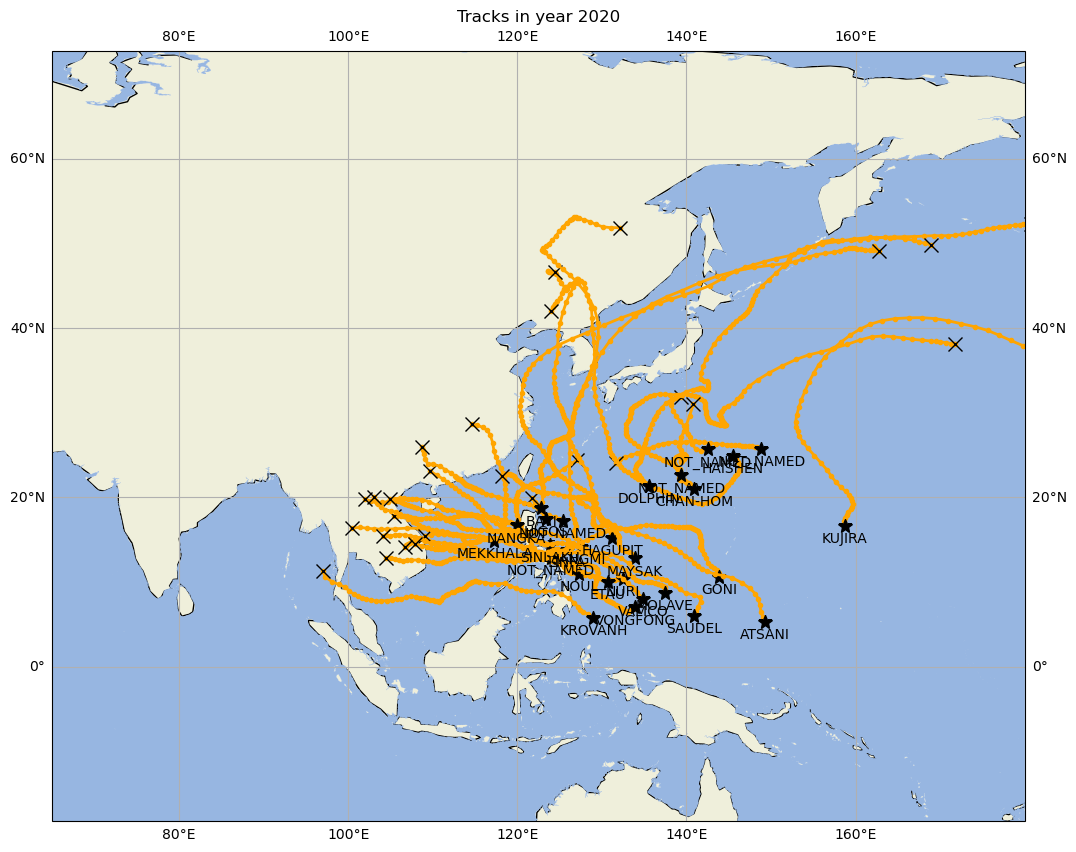

In [10]:

year=2020 # Change this to see tracks from other years.
storms = tks.where(tks.season==year, drop=True) # select the hurricanes that happened in selected year
print(f"There are {storms.dims['storm']} storms in the year {year}.\n")
storm_num = storms.dims['storm']
ax = map_background(extent=[65, 180, -10, 60], label=True)

for ind in range(storm_num):
  storm = storms.sel(storm=ind)
  plot_one_track(ax, storm, color='orange')
plt.title(f"Tracks in year {year}")
# plt.legend()

In [11]:
def get_moments(storm):
  # A function to calculate the track moments given a storm
  # OUTPUT:
  # X-centroid, Y-centroid, X_var, Y_var, XY_var

  # Note that:
  # In this case, no weights are set. In other words, all weights are 1.
  # A weight variable would need to be added in order to explore other weights

  lon_lst, lat_lst = get_lon_lat(storm)
  # If the track only has one point, there is no point in calculating the moments
  if len(lon_lst)<= 1: return None
      
  # M1 (first moment = mean). 
  # No weights applied
  lon_weighted, lat_weighted = np.mean(lon_lst), np.mean(lat_lst)
    
  # M2 (second moment = variance of lat and of lon / covariance of lat to lon
  # No weights applied
  cv = np.ma.cov([lon_lst, lat_lst])
    
  return [lon_weighted, lat_weighted, cv[0, 0], cv[1, 1], cv[0, 1]]

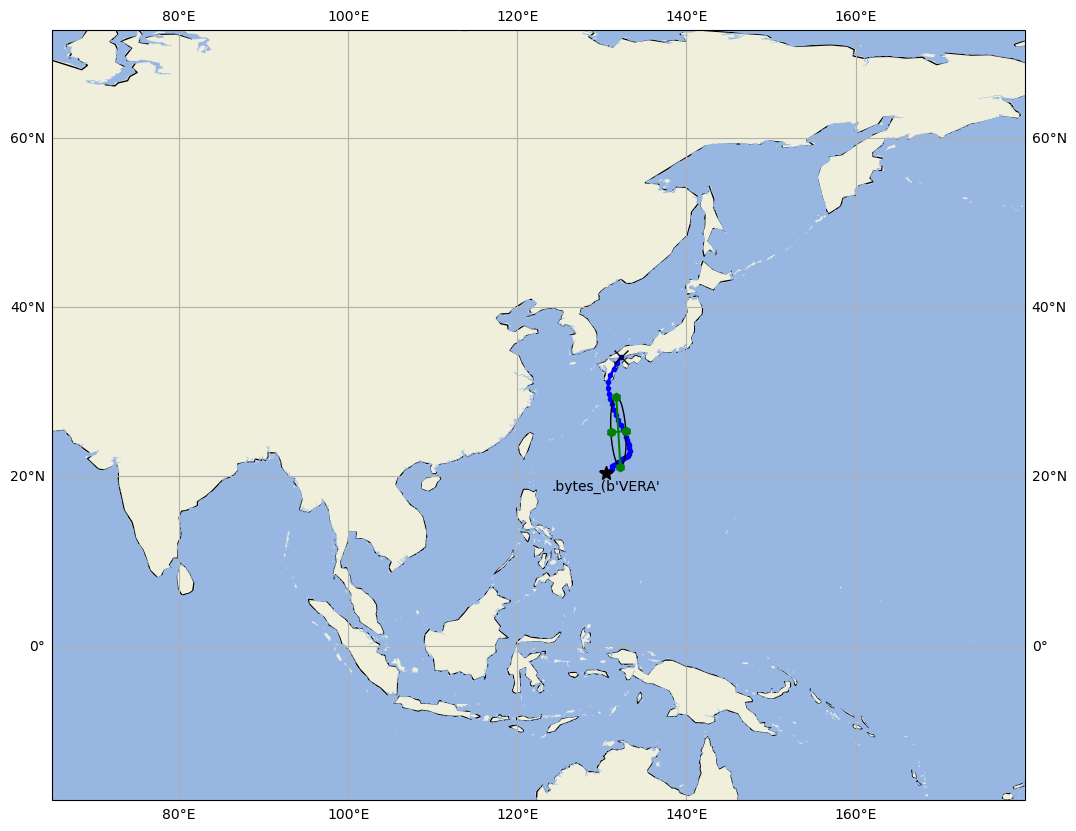

In [12]:
storm = tks.sel(storm=2000)
lon_weighted, lat_weighted, lon_var, lat_var, xy_var = get_moments(storm)

# Rotate the circle and calculate points on the circle
# Set N larger to make the oval more precise and to consume more electricity
N=1000
t = np.linspace(0, 2 * np.pi, N)
circle = [np.sqrt(lon_var) * np.cos(t), np.sqrt(lat_var) * np.sin(t)]
_, R_rot = LA.eig(np.array([[lon_var, xy_var], [xy_var, lat_var]]))
circle = np.dot(R_rot, circle)
R_1, R_2 = circle[0, :] + lon_weighted, circle[1, :] + lat_weighted

# Plot
ax = map_background(extent=[65, 180, -10, 60], label=True)
plot_one_track(ax, storm)
ax.plot(R_1, R_2, '-', color='black', linewidth=1)
ax.plot([circle[0,0], circle[0,int(N/2)]]+lon_weighted,
        [circle[1,0], circle[1,int(N/2)]]+lat_weighted, '-gh')
ax.plot([circle[0,int(N/4)], circle[0,int(N*3/4)]]+lon_weighted,
        [circle[1,int(N/4)], circle[1,int(N*3/4)]]+lat_weighted, '-gh')

In [13]:
# It takes a moment to calculate the moments.
moment_lst = [get_moments(tks.sel(storm=i)) for i in range(tks.dims['storm'])
              if get_moments(tks.sel(storm=i))]
print(np.shape(moment_lst))
print(f"There are {tks.dims['storm']-np.shape(moment_lst)[0]} tracks that have length less than 1.")

(4283, 5)
There are 6 tracks that have length less than 1.


Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

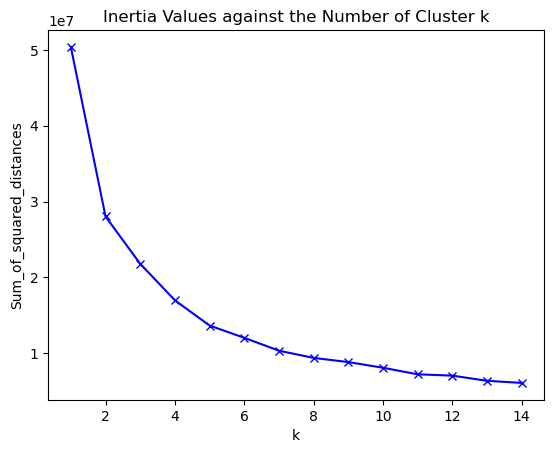

In [14]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

Text(0.5, 1.0, 'K-means clustering result, 6 clusters')

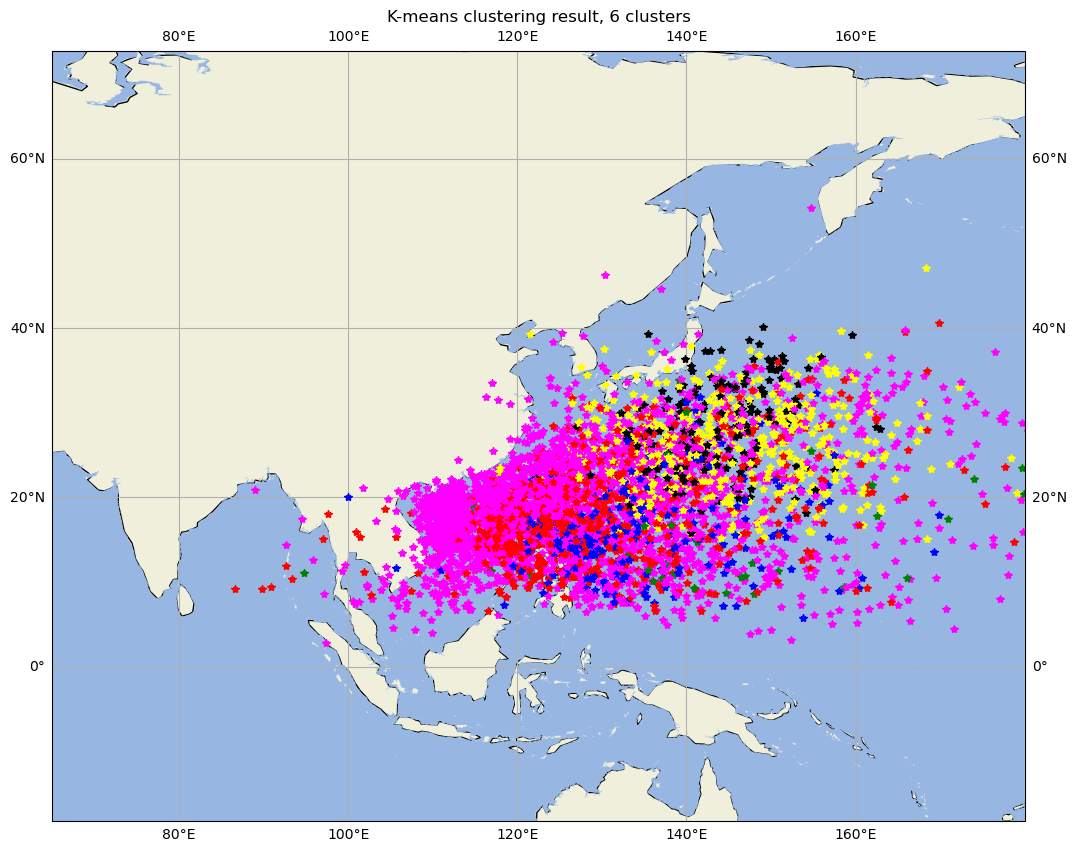

In [22]:
km = k_means(moment_lst, n_clusters=6)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
labels = km[1]
ax = map_background(extent=[65, 180, -10, 60], label=True)
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('K-means clustering result, 6 clusters')

Text(0.5, 1.0, 'K-means clustering result')

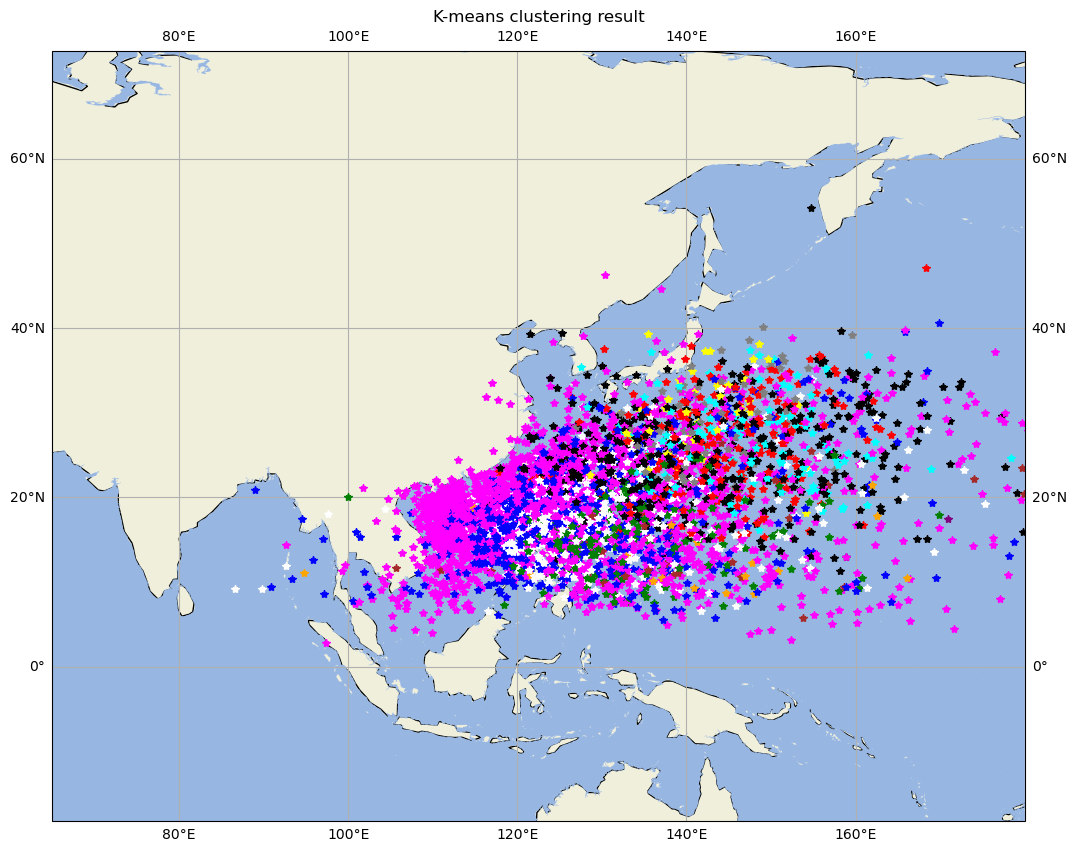

In [16]:
# consider a different number of clusters (colors set for up to 12, add more colors if you want more clusters)
km = k_means(moment_lst, n_clusters=12)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta','orange','gray','white','cyan','purple','brown']
labels = km[1]
ax = map_background(extent=[65, 180, -10, 60], label=True)
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('K-means clustering result')